In [1]:
##IMPORT STATEMENTS

""" This file is to test the mydel called mymodel """

import os
import cv2
import numpy as np
import random
import pathlib

import pickle #?

import tensorflow as tf
import tensorflow.keras.layers

from tensorflow.keras.layers import TimeDistributed

import matplotlib.pyplot as plt

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
import seaborn as sns

2023-03-20 09:38:34.817552: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 09:38:35.458604: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /dcs/19/u1901447/year4/project/ruck_and_roll/venv3/lib/python3.9/site-packages/cv2/../../lib64:/local/java/postgresql/lib/:/local/java/postgresql/lib/
2023-03-20 09:38:35.458644: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-20 09:38:35.583539: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register c

In [2]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [3]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [4]:
class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.mp4'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [5]:
# model = tf.saved_model.load("my_saved_model")
model = tf.keras.models.load_model("mymodel_batch",compile=False) #tf.keras.models.save_model
# model = model.load("mymodel_new")
# model = pickle.load(open("mymodel.pkl", "rb"))

2023-03-20 09:38:41.819652: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /dcs/19/u1901447/year4/project/ruck_and_roll/venv3/lib/python3.9/site-packages/cv2/../../lib64:/local/java/postgresql/lib/:/local/java/postgresql/lib/
2023-03-20 09:38:41.820316: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-20 09:38:41.820341: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (emu-16): /proc/driver/nvidia/version does not exist
2023-03-20 09:38:41.821294: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, reb

In [6]:



def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  # model.summary()

  # print("dataset columns", dataset.columns)
  # labeling = infer(tf.constant(dataset))["RUCK"] #?
  # print(labeling)

  # print(list(model.signatures.keys())) #"serving_default"
  # print(infer.structured_outputs) #{'global_average_pooling3d': TensorSpec(shape=(None, 13), dtype=tf.float32, name='global_average_pooling3d')}
  # tensor_data = next(iter(dataset))
  # predicted = infer(tf.constant(tensor_data))["global_average_pooling3d"]#[model.output_names[0]]
  
  predicted = model.predict(dataset)
  # predicted = model(dataset)


  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [7]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [8]:
# # Test Code
train_data_dir = pathlib.Path('/dcs/large/u1901447/videos/clips/data_35_frames/train')
# val_data_dir = pathlib.Path('/dcs/large/u1901447/videos/clips/data_35_frames/val')
# fg = FrameGenerator(train_data_dir, 25, training=True)

# print(fg.class_names)
# fg.class_ids_for_name

# frames, label = next(fg())

# print(f"Shape: {frames.shape}")
# print(f"Label: {label}")

# # Create the training set
# output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
#                     tf.TensorSpec(shape = (), dtype = tf.int16))
# train_ds = tf.data.Dataset.from_generator(FrameGenerator(train_data_dir, 25, training=True),
#                                           output_signature = output_signature)

# # Create the validation set
# val_ds = tf.data.Dataset.from_generator(FrameGenerator(val_data_dir, 25),
#                                         output_signature = output_signature)

# train_ds = train_ds.batch(8)
# val_ds = val_ds.batch(8)

fg = FrameGenerator(train_data_dir, 25, training=True)
labels = list(fg.class_ids_for_name.keys())
# actual, predicted = get_actual_predicted_labels(train_ds)


In [9]:
# plot_confusion_matrix(actual, predicted, labels, 'training')

29/29 [==============================] - 67s 2s/step


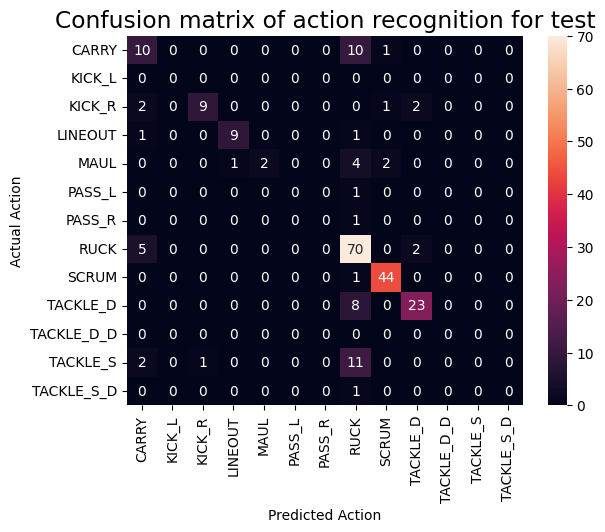

In [10]:
test_data_dir = pathlib.Path('/dcs/large/u1901447/videos/clips/data_35_frames/test')
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
n_frames = 25
test_ds = tf.data.Dataset.from_generator(FrameGenerator(test_data_dir, n_frames),
                                         output_signature = output_signature)
test_ds = test_ds.batch(8)

# Test Code Print the shapes of the data
# Test Code Print the shapes of the data

actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')